# ARIMA Time Series Forecasting

ARIMA model assumption - stationary: the time series has its statistical properties remain constant across time

ARIMA models combine three distinct components:
1. Autoregression, represented as AR
2. Differencing, represented as I
3. Moving average, represented as MA

Three components/parameters: AR + I + MA (p, d, q)

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Step 1: Load and Preprocess the Dataset

In [96]:
Canadian_data=pd.read_csv('Canadian Car Sales.csv')

Canadian_data.reset_index(inplace=True)
Canadian_data = Canadian_data[['REF_DATE', 'VALUE']]

Canadian_data['REF_DATE'] = pd.to_datetime(Canadian_data['REF_DATE'])

print(Canadian_data.dtypes)
Canadian_data.head()

REF_DATE    datetime64[ns]
VALUE              float64
dtype: object


,REF_DATE,VALUE
0,1953-01-01,21742.0
1,1953-02-01,28711.0
2,1953-03-01,36867.0
3,1953-04-01,39903.0
4,1953-05-01,37717.0


In [97]:
# Check for missing values
print(Canadian_data.isnull().sum())

REF_DATE    0
VALUE       0
dtype: int64


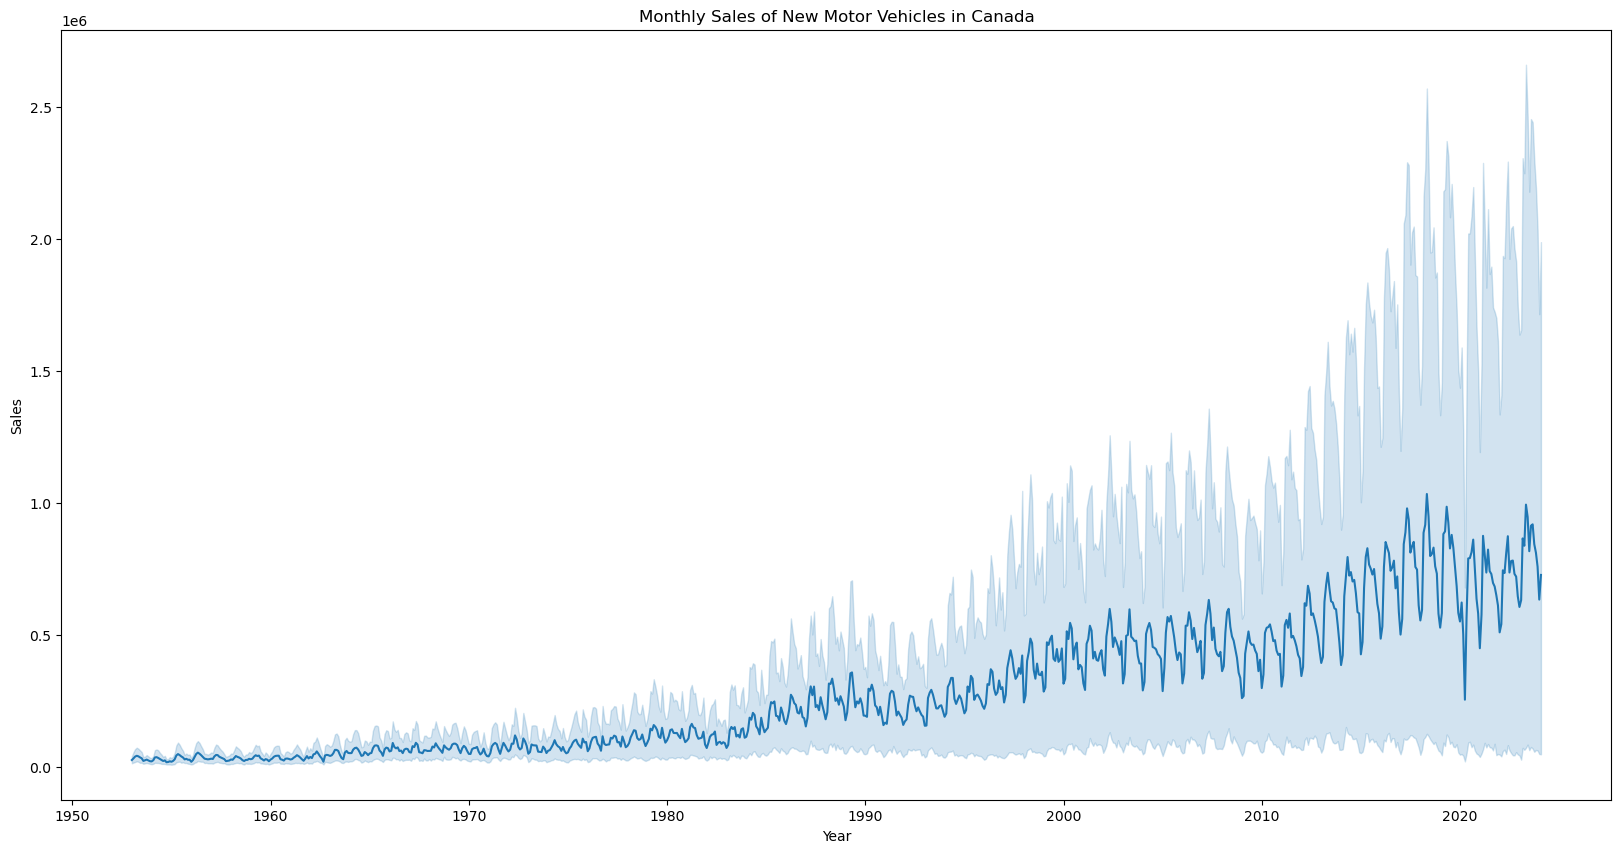

In [98]:
# Adjust figure size
plt.figure(figsize=(20, 10))

# Plot the lineplot
sns.lineplot(data=Canadian_data, x='REF_DATE', y='VALUE')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Monthly Sales of New Motor Vehicles in Canada')
plt.show()

## Step 2: Check for Stationarity

In [99]:
# Function to perform the Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Applying the Dickey-Fuller test on the 'VALUE' column
test_stationarity(Canadian_data['VALUE'])

Results of Dickey-Fuller Test:
Test Statistic                    7.998040
p-value                           1.000000
#Lags Used                       35.000000
Number of Observations Used    6546.000000
Critical Value (1%)              -3.431349
Critical Value (5%)              -2.861982
Critical Value (10%)             -2.567005
dtype: float64


If the p-value is less than 0.05 and the test statistic is less than the critical values, we can conclude the series is stationary.

But it is not, we'll consider applying transformations to make it stationary.

## Step 3: Data Transformation

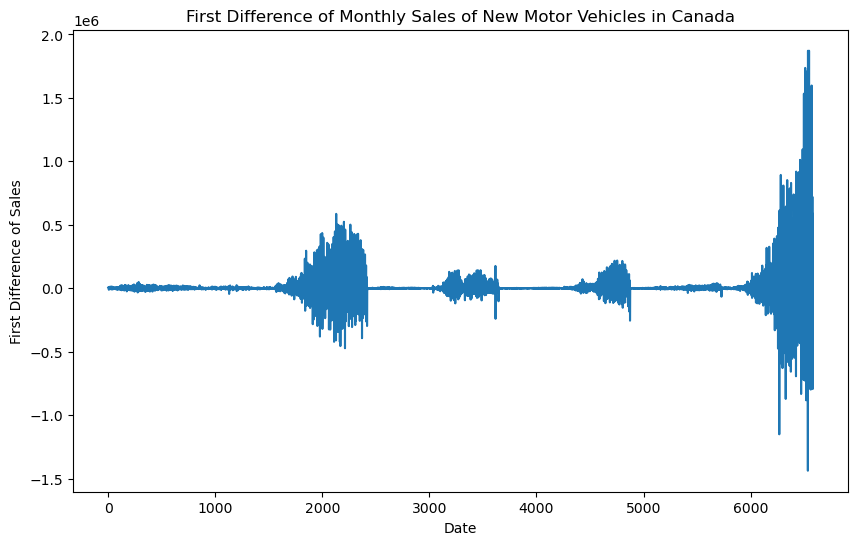

Results of Dickey-Fuller Test:
Test Statistic                -9.525575e+00
p-value                        2.984198e-16
#Lags Used                     3.500000e+01
Number of Observations Used    6.545000e+03
Critical Value (1%)           -3.431350e+00
Critical Value (5%)           -2.861982e+00
Critical Value (10%)          -2.567005e+00
dtype: float64


In [100]:
# First differencing
Canadian_data['VALUE_diff'] = Canadian_data['VALUE'].diff()

# Plot to see the effect of differencing
plt.figure(figsize=(10, 6))
plt.plot(Canadian_data['VALUE_diff'])
plt.title('First Difference of Monthly Sales of New Motor Vehicles in Canada')
plt.xlabel('Date')
plt.ylabel('First Difference of Sales')
plt.show()

# Re-run the ADF test
test_stationarity(Canadian_data['VALUE_diff'].dropna())

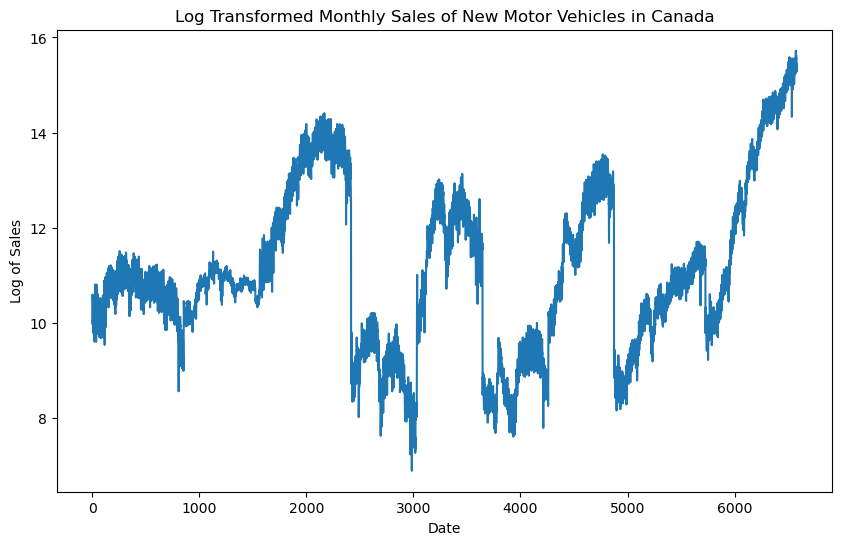

Results of Dickey-Fuller Test:
Test Statistic                   -1.565251
p-value                           0.501022
#Lags Used                       35.000000
Number of Observations Used    6546.000000
Critical Value (1%)              -3.431349
Critical Value (5%)              -2.861982
Critical Value (10%)             -2.567005
dtype: float64


In [101]:
# Log transformation
Canadian_data['VALUE_log'] = np.log(Canadian_data['VALUE'])

# Plot to see the effect of logarithmic transformation
plt.figure(figsize=(10, 6))
plt.plot(Canadian_data['VALUE_log'])
plt.title('Log Transformed Monthly Sales of New Motor Vehicles in Canada')
plt.xlabel('Date')
plt.ylabel('Log of Sales')
plt.show()

# Re-run the ADF test
test_stationarity(Canadian_data['VALUE_log'].dropna())

Lambda for Box-Cox Transformation: -0.09487739199675656


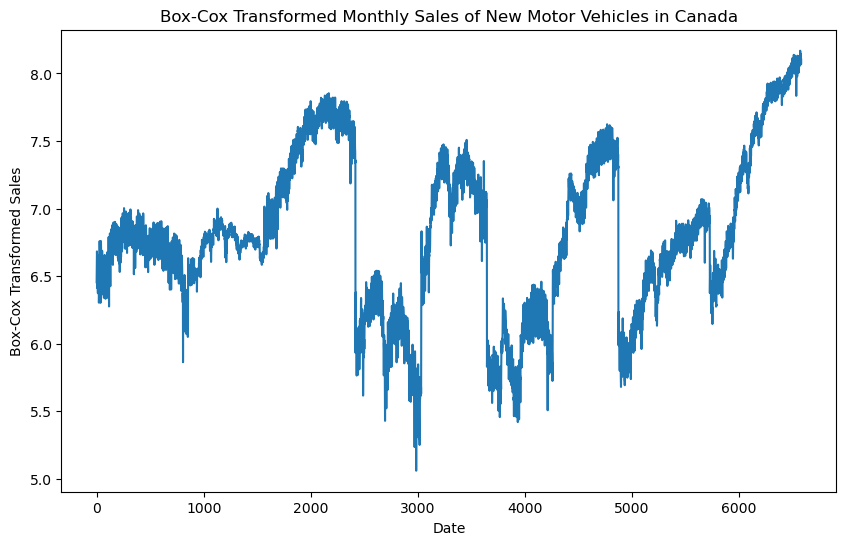

Results of Dickey-Fuller Test:
Test Statistic                   -1.955880
p-value                           0.306247
#Lags Used                       35.000000
Number of Observations Used    6546.000000
Critical Value (1%)              -3.431349
Critical Value (5%)              -2.861982
Critical Value (10%)             -2.567005
dtype: float64


In [102]:
from scipy.stats import boxcox

# Box-Cox transformation
Canadian_data['VALUE_boxcox'], lam = boxcox(Canadian_data['VALUE'])

# Store lambda for later inverse transformation if needed
print("Lambda for Box-Cox Transformation:", lam)

# Plot to see the effect of Box-Cox transformation
plt.figure(figsize=(10, 6))
plt.plot(Canadian_data.index, Canadian_data['VALUE_boxcox'])
plt.title('Box-Cox Transformed Monthly Sales of New Motor Vehicles in Canada')
plt.xlabel('Date')
plt.ylabel('Box-Cox Transformed Sales')
plt.show()

# Re-run the ADF test
test_stationarity(Canadian_data['VALUE_boxcox'].dropna())


Box-Cox Transformation has the lowest p-value, hence use VALUE_boxcox for future steps

In [103]:
#check for duplicates
print(Canadian_data.duplicated().sum())

# Drop NA values that are generated by differencing
Canadian_data = Canadian_data.dropna()

0


## Step 4: Identify and Remove Outliers

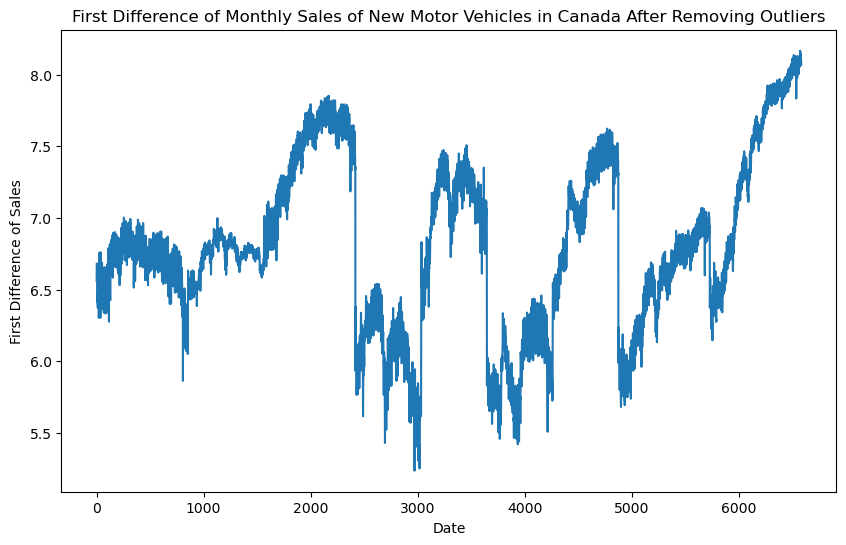

In [104]:
# Calculate IQR
Q1 = Canadian_data['VALUE_boxcox'].quantile(0.25)
Q3 = Canadian_data['VALUE_boxcox'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
filtered_data = Canadian_data[(Canadian_data['VALUE_boxcox'] >= lower_bound) & (Canadian_data['VALUE_boxcox'] <= upper_bound)]

# Plot to see data after removing outliers
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['VALUE_boxcox'])
plt.title('First Difference of Monthly Sales of New Motor Vehicles in Canada After Removing Outliers')
plt.xlabel('Date')
plt.ylabel('First Difference of Sales')
plt.show()


## Step 5: Split the Data into Training and Test Sets

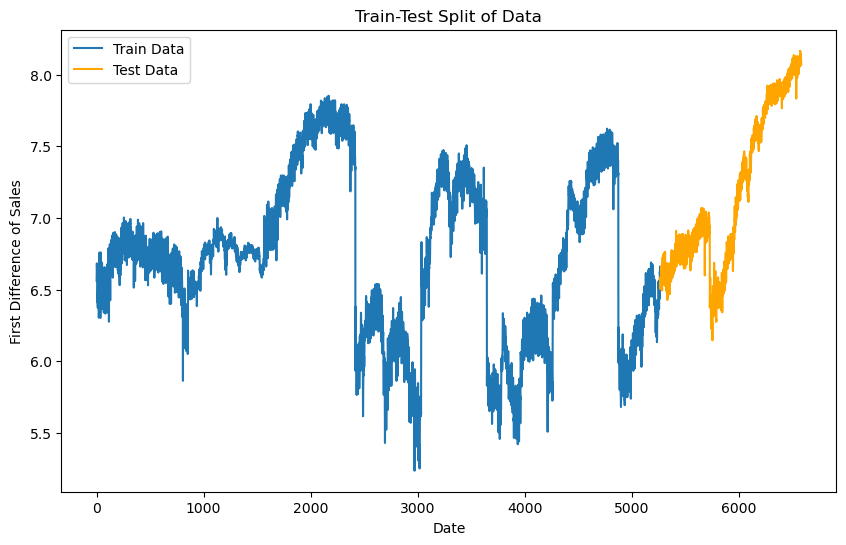

In [105]:
# Calculate the split point
split_point = int(len(filtered_data) * 0.8)

# Split into training and test sets
train_data = filtered_data[:split_point]
test_data = filtered_data[split_point:]

# Plot both to visually inspect the split
plt.figure(figsize=(10, 6))
plt.plot(train_data['VALUE_boxcox'], label='Train Data')
plt.plot(test_data['VALUE_boxcox'], label='Test Data', color='orange')
plt.title('Train-Test Split of Data')
plt.xlabel('Date')
plt.ylabel('First Difference of Sales')
plt.legend()
plt.show()

## Step 6: Model Identification

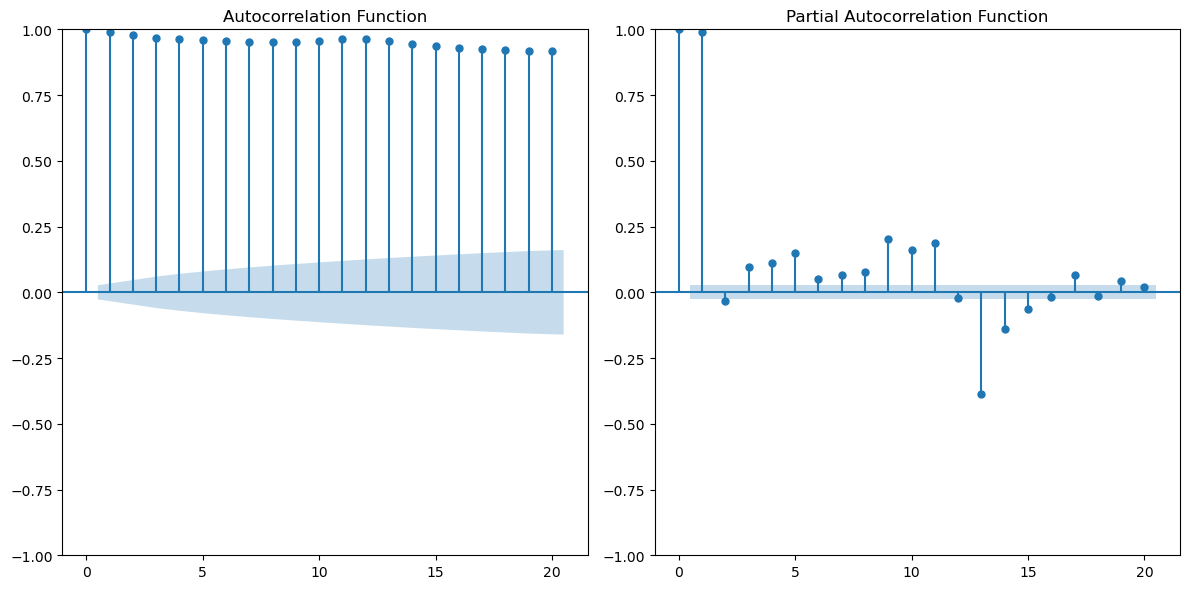

In [106]:
# Plot ACF and PACF for the differenced data
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(train_data['VALUE_boxcox'], ax=plt.gca(), lags=20)
plt.title('Autocorrelation Function')

plt.subplot(122)
plot_pacf(train_data['VALUE_boxcox'], ax=plt.gca(), lags=20)
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()


## Step 7: Model Fitting

/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           VALUE_boxcox   No. Observations:                 5264
Model:                 ARIMA(1, 1, 1)   Log Likelihood                5790.216
Date:                Fri, 19 Apr 2024   AIC                         -11574.432
Time:                        21:45:43   BIC                         -11554.727
Sample:                             0   HQIC                        -11567.543
                               - 5264                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7453      0.019     38.860      0.000       0.708       0.783
ma.L1         -0.8836      0.013    -66.434      0.000      -0.910      -0.858
sigma2         0.0065   2.59e-05    250.489      0.0

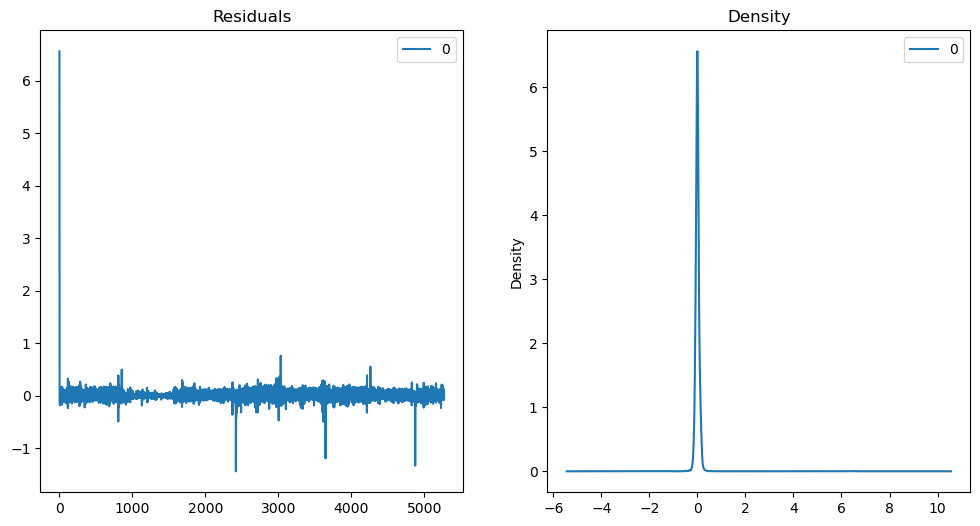

In [107]:
# Assuming p=1, d=1, q=1 from the previous identification step
model = ARIMA(train_data['VALUE_boxcox'], order=(1, 1, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Check residuals
residuals = pd.DataFrame(model_fit.resid)
plt.figure(figsize=(12, 6))
plt.subplot(121)
residuals.plot(title="Residuals", ax=plt.gca())
plt.subplot(122)
residuals.plot(kind='kde', title='Density', ax=plt.gca())
plt.show()

### ARIMA Model Evaluation Summary

#### Model Fit Statistics
- **Log Likelihood**: 5790.216
  - High log likelihood indicates a good fit to the data.
- **AIC (Akaike Information Criterion)**: -11574.432
  - Lower AIC values suggest a better model, with a negative value indicating a very strong model.
- **BIC (Bayesian Information Criterion)**: -11554.727
  - Lower BIC values also suggest a better model, with more strict penalties for models with more parameters.

#### Parameter Estimates
- **ar.L1 (AR1 coefficient)**: 0.7453 (p-value near 0)
  - Significant positive autocorrelation at lag 1.
- **ma.L1 (MA1 coefficient)**: -0.8836 (p-value near 0)
  - Significant negative coefficient, indicating a significant moving average component.

#### Model Diagnostics
- **sigma2**: 0.0065
  - Low estimated variance of residuals suggests a good model fit.
- **Ljung-Box Test**: Statistic = 69.16, p-value ≈ 0
  - Indication of remaining autocorrelation in residuals at lag 1, suggesting potential model improvement.
- **Jarque-Bera Test**: Statistic = 475193.70, p-value = 0
  - The residuals are not normally distributed, indicating issues such as heavy tails or skewness.
- **Heteroskedasticity Test**: Statistic = 1.78, p-value = 0
  - Significant heteroskedasticity detected, implying varying error variance.

#### Skewness and Kurtosis
- **Skew**: -2.26
  - Left-skewed distribution of residuals.
- **Kurtosis**: 49.33
  - Indicates leptokurtosis, suggesting heavy tails compared to a normal distribution.


## Step 8: Model Evaluation and Forecasting

/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


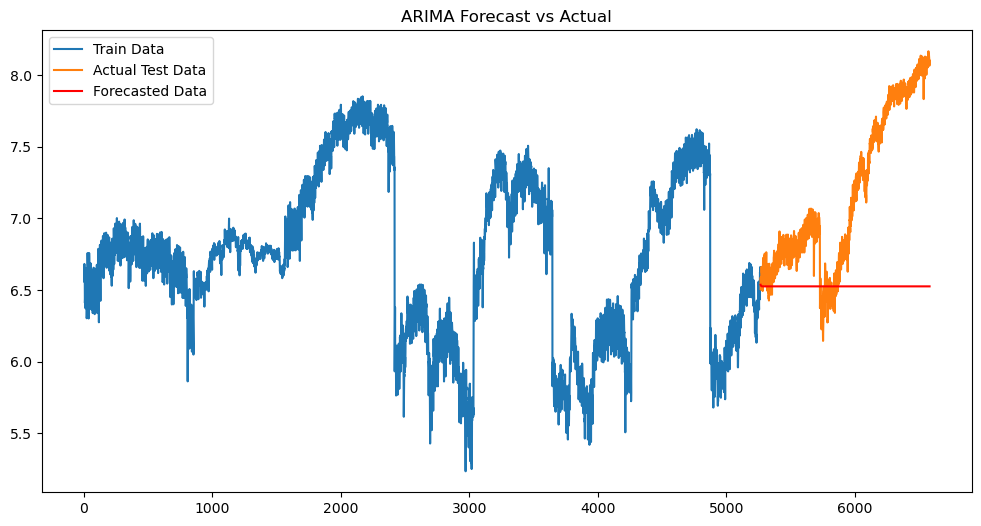

MSE: 0.7418876672585624, MAE: 0.6798012966121902, RMSE: 0.8613290122006586


In [108]:
# Make forecast
forecast = model_fit.forecast(steps=len(test_data))

# Visual comparison
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['VALUE_boxcox'], label='Train Data')
plt.plot(test_data.index, test_data['VALUE_boxcox'], label='Actual Test Data')
plt.plot(test_data.index, forecast, label='Forecasted Data', color='red')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.show()

# Calculate performance metrics
mse = mean_squared_error(test_data['VALUE_boxcox'], forecast)
mae = mean_absolute_error(test_data['VALUE_boxcox'], forecast)
rmse = np.sqrt(mse)
print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}')

### Forecast Accuracy Metrics

- **Mean Squared Error (MSE)**: 0.7418876672585624
  - MSE is the average of the squared differences between the predicted and actual values. It places greater weight on larger errors, making it sensitive to outliers.

- **Mean Absolute Error (MAE)**: 0.6798012966121902
  - MAE is the average absolute difference between the predicted and actual values, providing a straightforward measure of the average error magnitude.

- **Root Mean Squared Error (RMSE)**: 0.8613290122006586
  - RMSE is the square root of the MSE and is in the same units as the data. Like MSE, RMSE is sensitive to large errors and provides a measure of the typical error magnitude.
